In [1]:
# get all libraries

import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import time
import warnings
import contextlib

from sklearn import metrics
from sklearn.metrics import make_scorer,classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders import TargetEncoder

from hyperopt import hp, fmin, tpe,Trials
from IPython.display import HTML

import ydata_profiling
from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import DiscriminationThreshold


D:\Anaconda\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\adpur\AppData\Roaming\Python\Python38\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


the dataset has these features:
* Unit Number - The unique identifier for a Engine type
*  Cycle - Elapsed Cycle
*  3 operational Settings
*  21  Sensor Settings

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
# Read the training Dataset
# List of dataset file names
#data_files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']

data_files = ['train_FD001.txt']
# Initialize an empty DataFrame to hold the combined data
combined_train_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'predictive-maintenance',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_train_df = pd.concat([combined_train_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_train_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt


In [4]:
combined_train_df.shape

(20631, 27)

In [5]:
combined_train_df.groupby('source_file').count()[['unit_number']].reset_index()

,source_file,unit_number
0,train_FD001.txt,20631


In [6]:
# Read the Validation Dataset
# List of dataset file names
#data_files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']

data_files = ['test_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
combined_test_df = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
        osp.curdir,'predictive-maintenance',file)
    
    temp_df = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=col_names)
    temp_df['source_file'] = file
    
    # Concatenate the temporary DataFrame into the combined DataFrame
    combined_test_df = pd.concat([combined_test_df, temp_df], ignore_index=True)
    
# Show the first 5 rows of the combined DataFrame
combined_test_df.head(5)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,test_FD001.txt
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,test_FD001.txt
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,test_FD001.txt
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,test_FD001.txt
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,test_FD001.txt


In [7]:
combined_test_df.shape

(13096, 27)

In [8]:
combined_test_df.groupby('source_file').count()[['unit_number']].reset_index()

,source_file,unit_number
0,test_FD001.txt,13096


In [9]:
# Read the prediction values
# List of dataset file names
#data_files = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

data_files = ['RUL_FD001.txt']

# Initialize an empty DataFrame to hold the combined data
y_final = pd.DataFrame()

for file in data_files:
    data_path = osp.join(
  osp.curdir,'predictive-maintenance',file)
    
    y_temp = pd.read_csv(data_path,sep='\s+',header=None,index_col=False,names=['RUL'])
    y_temp['source_file'] = file
    
    y_final = pd.concat([y_final, y_temp], ignore_index=True)


y_final.head(5)

,RUL,source_file
0,112,RUL_FD001.txt
1,98,RUL_FD001.txt
2,69,RUL_FD001.txt
3,82,RUL_FD001.txt
4,91,RUL_FD001.txt


In [10]:
y_final.shape

(100, 2)

In [11]:
y_final.groupby('source_file').count()[['RUL']].reset_index()

,source_file,RUL
0,RUL_FD001.txt,100


Calculating the Remaining Useful Life (RUL) is a key aspect when working with the NASA Turbo Fan Jet Engine dataset. The dataset usually consists of multiple engines, each identified by a unit number, and for each engine, we have multiple cycles. The last cycle for each engine usually signifies failure. The idea is to calculate the RUL for each cycle as a countdown to this last cycle.

In [12]:
# create a function to calculate RUL

def calculate_RUL(df):
    # Sort the DataFrame by 'unit_number' and 'time_in_cycles'
    df = df.sort_values(['unit_number', 'time_cycles'])
    
    # Calculate max cycle for each unit
    max_cycle_df  = df.groupby('unit_number')['time_cycles'].max().reset_index()
    max_cycle_df.columns = ['unit_number', 'max_cycle']
    
    # Merge the max cycle back into the original dataframe
    df = df.merge(max_cycle_df, on='unit_number', how='left')
    
    # Calculate RUL for each row
    df['RUL'] = df['max_cycle'] - df['time_cycles']
    
    # Drop the max_cycle column
    df = df.drop('max_cycle', axis=1)
    return df

In [13]:
#Apply the function on the Train set
train_df= calculate_RUL(combined_train_df)
train_df.head(10)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,source_file,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,train_FD001.txt,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,train_FD001.txt,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,train_FD001.txt,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,train_FD001.txt,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,train_FD001.txt,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,train_FD001.txt,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,train_FD001.txt,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,train_FD001.txt,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,train_FD001.txt,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,train_FD001.txt,182


In [14]:
#examine the datatype of the train set
train_df.dtypes

unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
sensor_1       float64
sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_5       float64
sensor_6       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_10      float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_16      float64
sensor_17        int64
sensor_18        int64
sensor_19      float64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

In [15]:
print(train_df.isnull().sum())

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
sensor_1       0
sensor_2       0
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10      0
sensor_11      0
sensor_12      0
sensor_13      0
sensor_14      0
sensor_15      0
sensor_16      0
sensor_17      0
sensor_18      0
sensor_19      0
sensor_20      0
sensor_21      0
source_file    0
RUL            0
dtype: int64


In [16]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


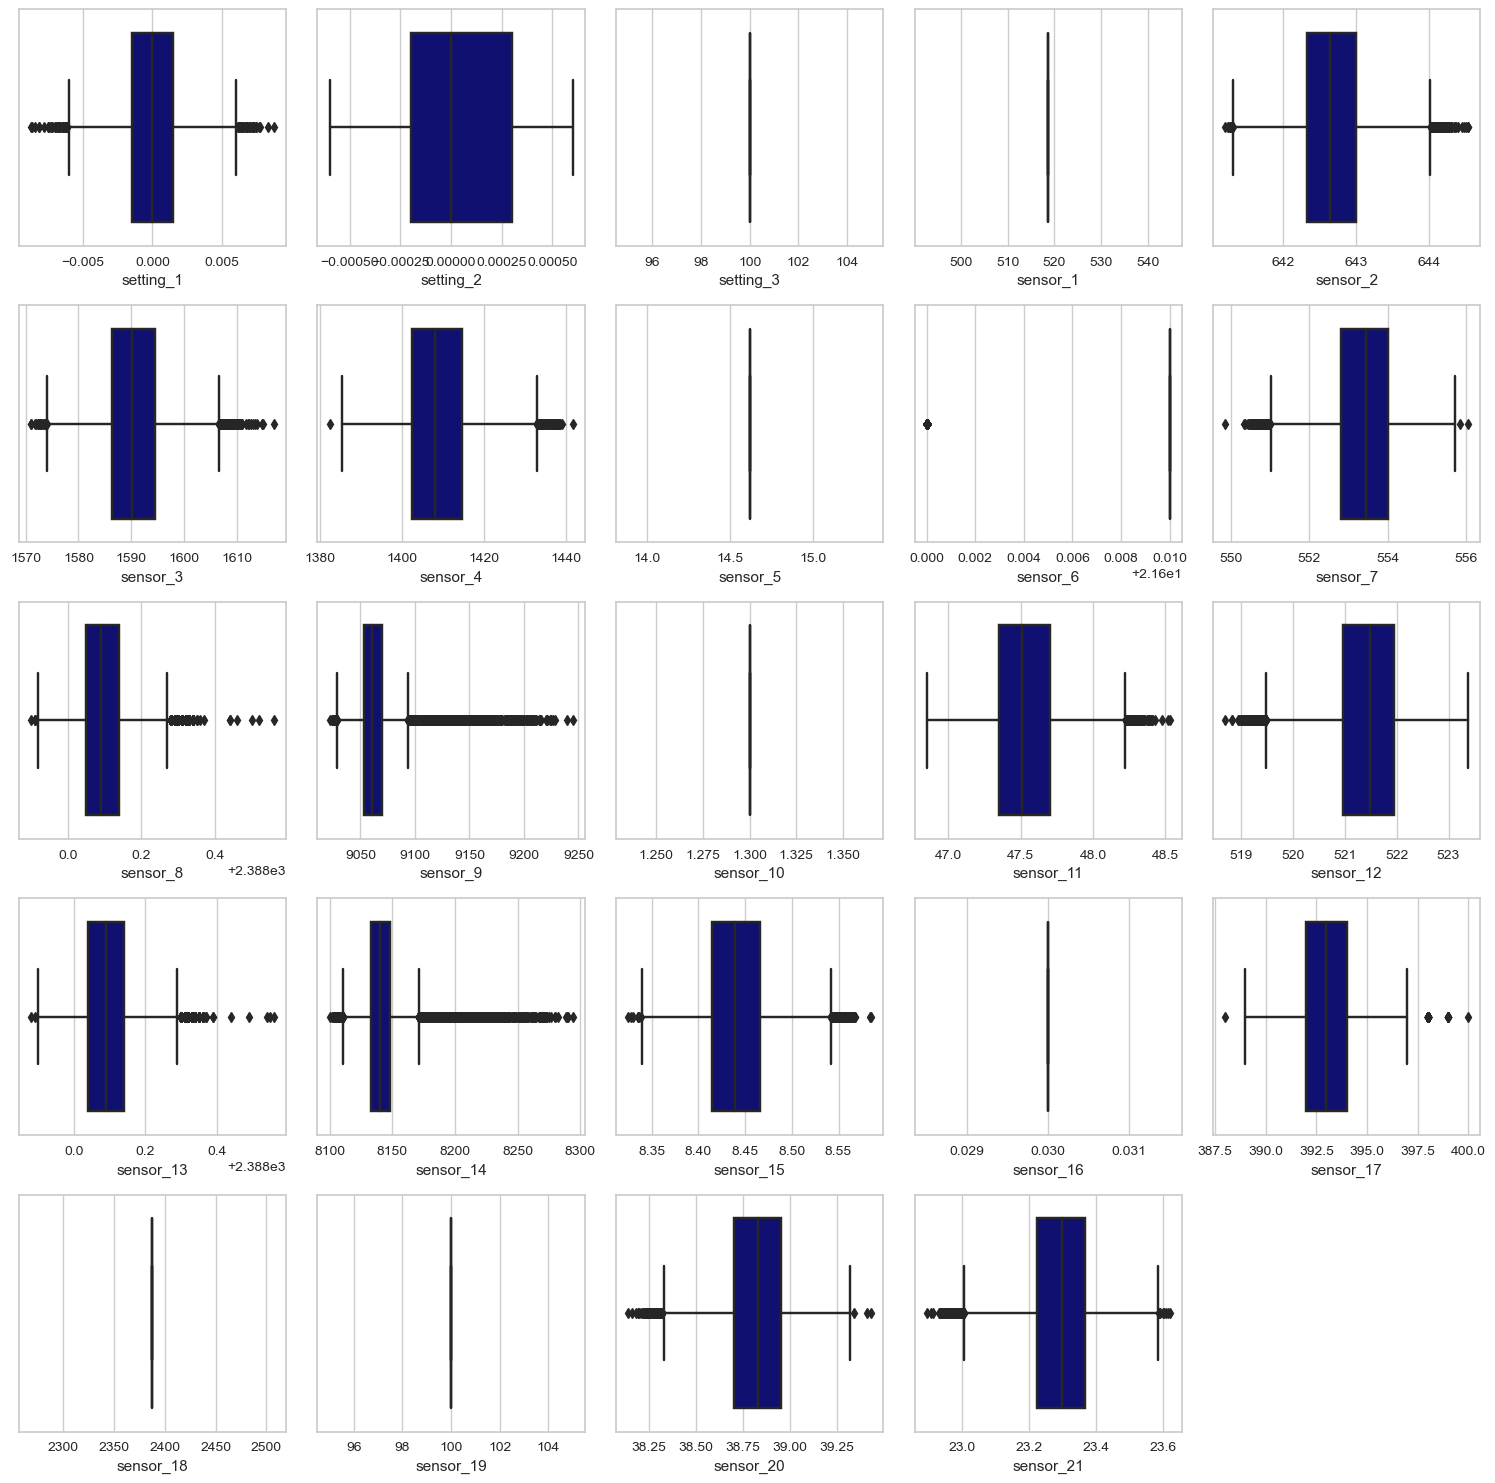

In [17]:
 # EDA for settings and sensors
numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, 
                        figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.boxplot(x=var,data=train_df, ax=axs[i],color="navy")

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


<Axes: >

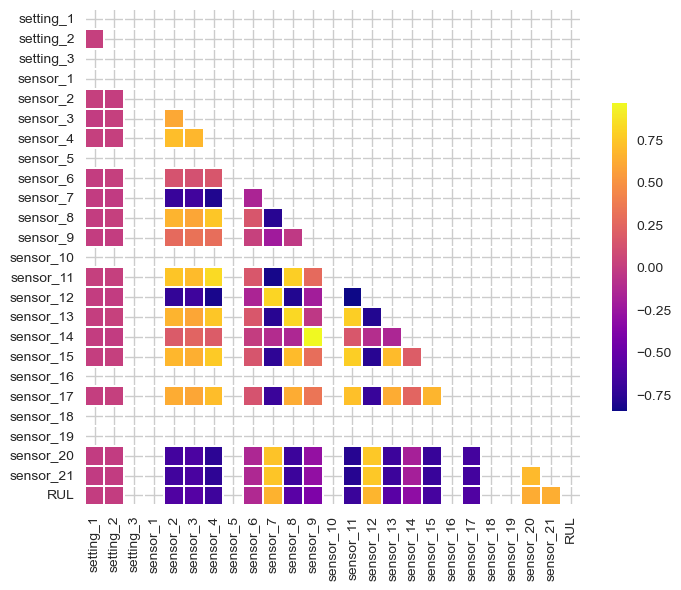

In [18]:
#examine correlations in the train DF
corr_cols = setting_names + sensor_names + ['RUL']
corr = train_df[corr_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='plasma', square=True, linewidths=.01, cbar_kws={"shrink": .5})

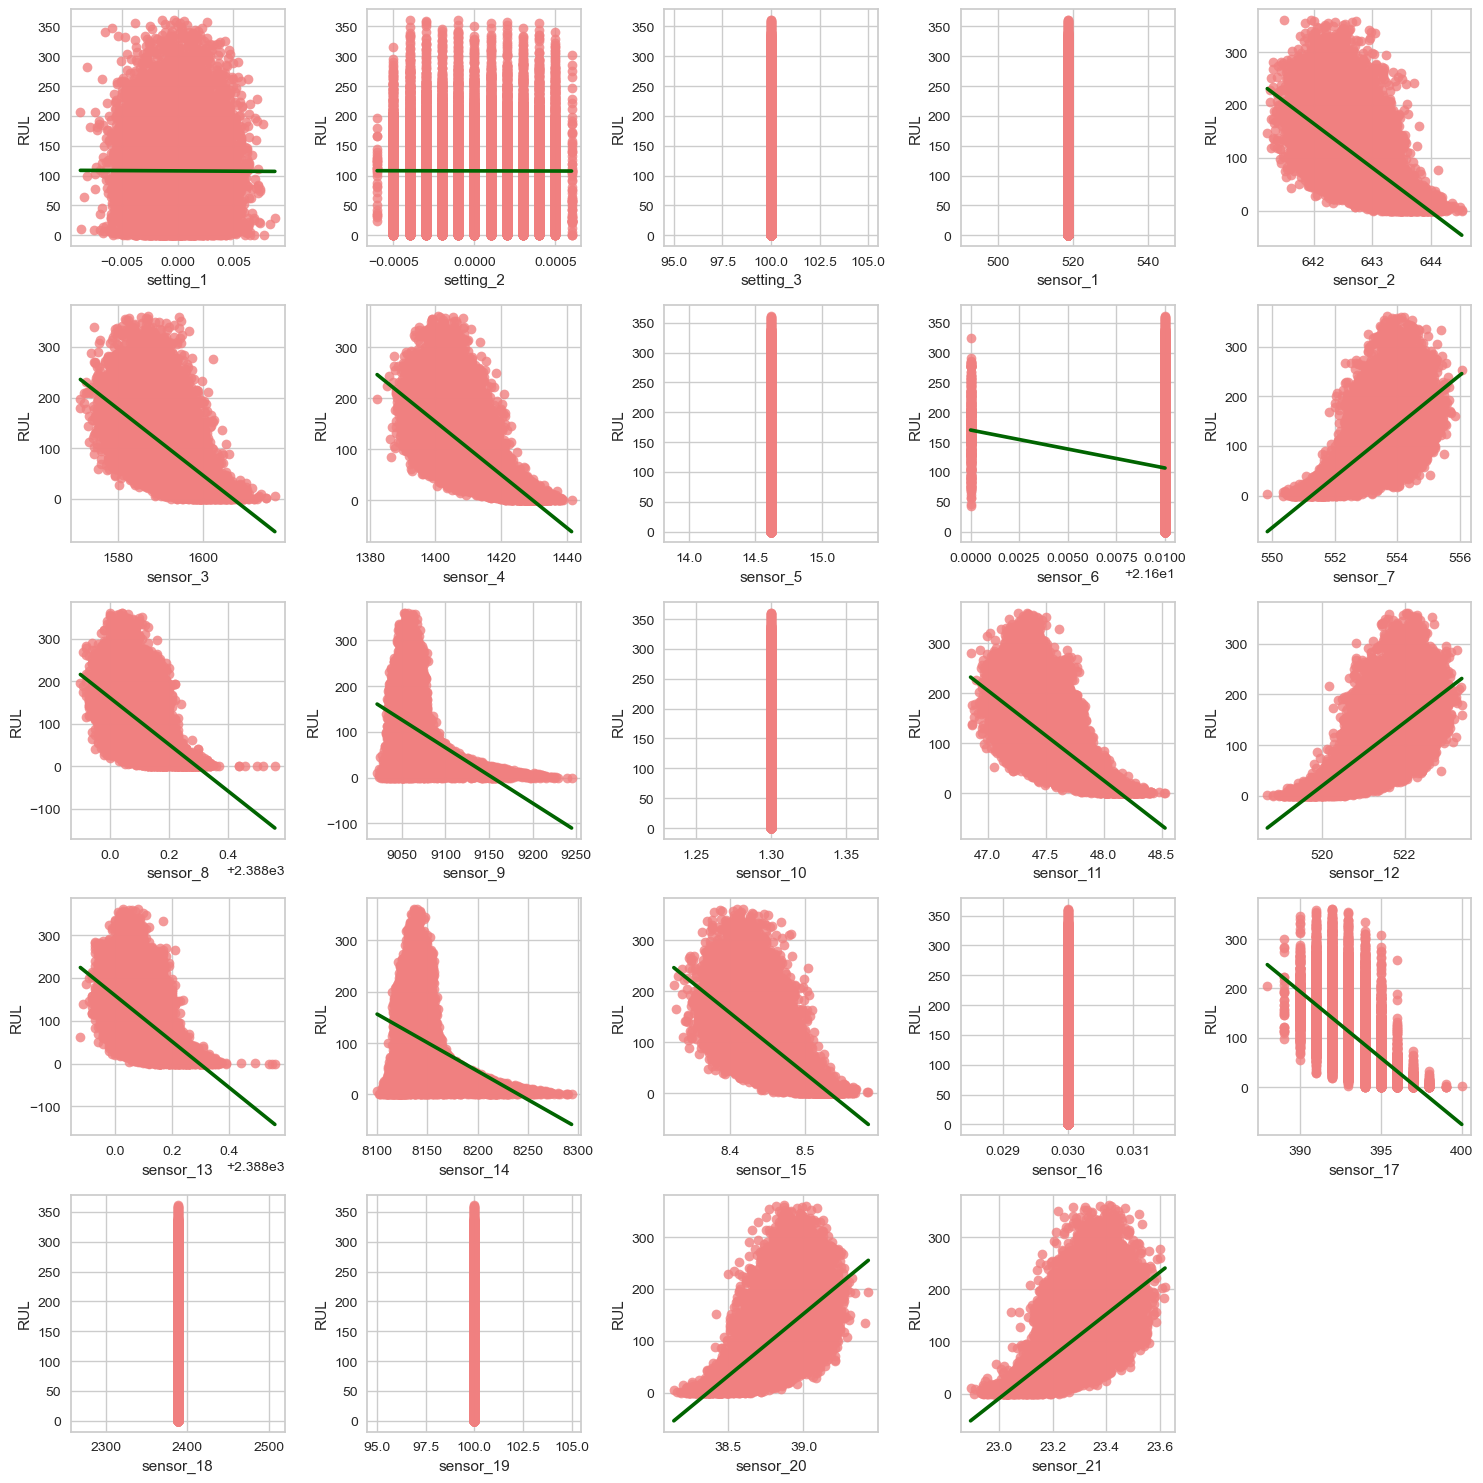

In [19]:
# Do some more EDA w.r.t. to the target

numeric_cols = setting_names + sensor_names
num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3 * total_cols, 3 * total_rows))

# Flatten the axs array to make it easier to index
axs = axs.flatten()

for i, var in enumerate(numeric_cols):
    sns.regplot(x=var, y="RUL", data=train_df, ax=axs[i], ci=False, 
                line_kws={'color': 'darkgreen'},scatter_kws={'color': 'lightcoral'})

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


From the above plots, it appears as these sensor values may be constant values or without any correlation with RUL
* setting_1
* setting_2
* setting_3
* sensor_1
* sensor_5
* sensor_6
* sensor_10
* sensor_16
* sensor_18
* sensor_19

We can generate some histograms to confirm if our suspicions are true

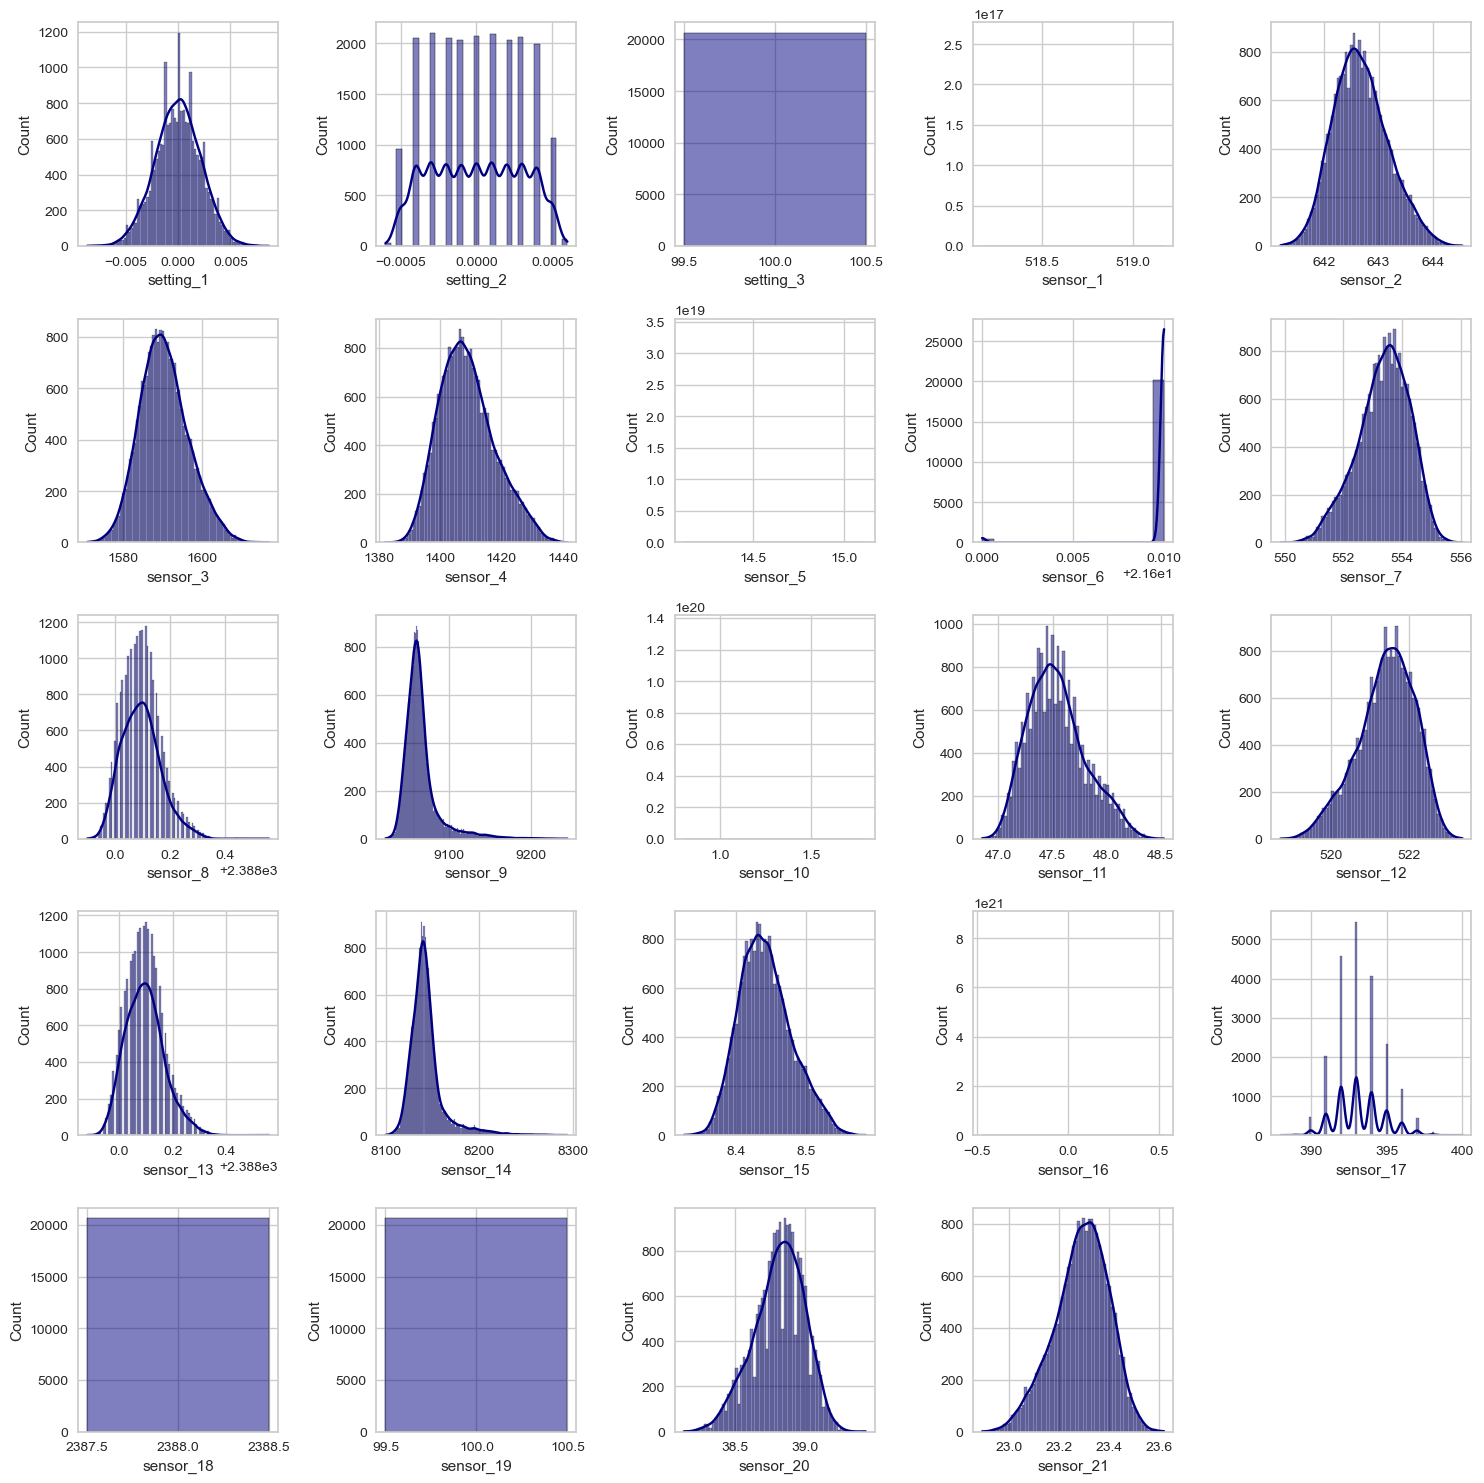

In [20]:
numeric_cols = setting_names + sensor_names

num_plots = len(numeric_cols)
total_cols = 5
total_rows = num_plots // total_cols
total_rows += 1 if num_plots % total_cols > 0 else 0  # Add an extra row if there are remaining plots

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(3* total_cols, 3 * total_rows))

# Flatten the axs array if total_rows > 1
axs = axs.flatten() if total_rows > 1 else axs

for i, var in enumerate(numeric_cols):
    sns.histplot(data=train_df, x=var, kde=True, color="navy", ax=axs[i])

# Remove unused subplots
for i in range(num_plots, total_cols * total_rows):
    fig.delaxes(axs[i])

fig.tight_layout()


Our suspicions are confirmed and we will drop these features for our model building. Lets proceed now to split our data into train-test sets and comparing various regression models on our data

In [21]:
drop_list = ["setting_1","setting_2","setting_3","sensor_1","sensor_5","sensor_6",
             "sensor_10","sensor_16","sensor_18","sensor_19"] + index_names
train_df_mod = train_df.drop(columns=drop_list)
train_df_mod.dtypes

sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_17        int64
sensor_20      float64
sensor_21      float64
source_file     object
RUL              int64
dtype: object

In [22]:
# importing various regression algorithms
# Linear Models
from sklearn.linear_model import LinearRegression

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Ensemble Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

# XGBoost
from xgboost import XGBRegressor

# LightGBM
from lightgbm import LGBMRegressor

# CatBoost
from catboost import CatBoostRegressor


In [23]:
#split training data into train and set split
X  = train_df_mod.drop(columns=["RUL","source_file"])
Y = train_df_mod["RUL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [24]:
X_train.shape

(16504, 14)

In [25]:
y_train.shape

(16504,)

In [26]:
X_test.shape

(4127, 14)

In [27]:
y_test.shape

(4127,)

### Create a function to evaluate various algorithms with Default Params

In [28]:
# Helper function
def quick_evaluate(X_train, X_test, y_train, y_test, name):
    
       
    lr = LinearRegression()
    dtr = DecisionTreeRegressor(random_state=42)
    rfr = RandomForestRegressor(random_state=42)
    gbr = GradientBoostingRegressor(random_state=42)
    abr = AdaBoostRegressor(random_state=42)
    svr = SVR(kernel='linear')
    knr = KNeighborsRegressor()
    xgr = XGBRegressor(random_state=42)
    lgbmr = LGBMRegressor(random_state=42)
    catr = CatBoostRegressor(random_state=42,verbose=0)
  

      
    regressors = [('LR', lr),('DT', dtr),
                   ('RF', rfr),('GB', gbr),('AB', abr),
                   ('SV', svr),('KN', knr),('XB', xgr),
                  ('LB', lgbmr),('CB', catr)
                 ]
   
    n = len(y_test)
    p = X_test.shape[1]
        
    reg_lst = list()
    for reg_name, reg in regressors:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        R2             = metrics.r2_score(y_test, y_pred)
        ADJ_R2         = 1 - (1-R2)*(n-1)/(n-p-1)
        MAPE           = metrics.mean_absolute_percentage_error(y_test,y_pred)
        MAE            = metrics.mean_absolute_error(y_test,y_pred)
        MSE            = metrics.mean_squared_error(y_test,y_pred)
        RMSE           = np.sqrt(metrics.mean_squared_error(y_test, y_pred))       
        params         = reg.get_params()
        
        df = pd.DataFrame({
                           "Method"    : [name],
                           "Regressor" : [reg_name],
                           "R2"        : [R2],
                           "Adj_R2"    : [ADJ_R2],
                           #"MAPE"      : [MAPE],
                           "MAE"       : [MAE],
                           "MSE"       : [MSE],                           
                           "RMSE"      : [RMSE],                            
                           "Model"     : [params]
                          })
        reg_lst.append(df)
    print(reg_lst)
    dfr = pd.concat([m for m in reg_lst], axis = 0).reset_index()
    dfr = dfr.drop(columns = "index",axis =1)
    return(dfr)

Pass#1 evaluate without scaling

In [29]:
with contextlib.redirect_stdout(None):
    evals = list()
    evals.append(quick_evaluate(X_train, X_test, y_train, y_test,'unscaled'))

Pass#2 evaluate with scaled features

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train_s = sscaler.fit_transform(X_train)
X_test_s =  sscaler.transform(X_test)

X_train_m = mscaler.fit_transform(X_train)
X_test_m =  mscaler.transform(X_test)

In [31]:
with contextlib.redirect_stdout(None):
    #Standard scaling evaluation
    evals.append(quick_evaluate(X_train_s, X_test_s, y_train, y_test,'Standard'))
    
    #Minmax scaling evaluation
    evals.append(quick_evaluate(X_train_m, X_test_m, y_train, y_test,'MinMax'))

In [33]:
#evaluate results
pd.set_option('max_colwidth', 100)
evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['R2','MAE'], ascending=False)

,Method,Regressor,R2,Adj_R2,MAE,MSE,RMSE,Model
2,unscaled,RF,0.626206,0.624933,29.513181,1707.789665,41.325412,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
12,Standard,RF,0.626086,0.624813,29.520565,1708.336554,41.332028,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
22,MinMax,RF,0.625910,0.624636,29.518054,1709.141985,41.341770,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_feat..."
13,Standard,GB,0.625303,0.624027,29.900432,1711.915883,41.375305,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
3,unscaled,GB,0.625297,0.624021,29.901806,1711.941049,41.375609,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
23,MinMax,GB,0.625293,0.624018,29.900990,1711.958162,41.375816,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1..."
18,Standard,LB,0.625250,0.623974,29.543734,1712.157330,41.378223,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
28,MinMax,LB,0.624344,0.623065,29.719742,1716.296642,41.428211,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
8,unscaled,LB,0.623358,0.622076,29.665292,1720.798250,41.482505,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'spl..."
9,unscaled,CB,0.621970,0.620683,29.686515,1727.141388,41.558891,"{'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}"


In [ ]:
rf_params = {
    'n_estimators':[100],
    'min_samples_split':range(2, 11),    
    'max_samples':[0.7,0.8,0.9]
}

gridsearch_rf = GridSearchCV(RandomForestRegressor(), 
                             rf_params,  
                             cv=10,
                             scoring ='r2',                            
                             n_jobs = -1, 
                             verbose=3 
                             )

%time gridsearch_rf.fit(X_train, y_train)


y_pred_rf = gridsearch_rf.predict(X_test)

# Evaluation
print("R2 Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


In [ ]:
print('Initial score: ', gridsearch_rf.best_score_)
print('Initial parameters: ', gridsearch_rf.best_params_)